Analysis
- A three-month forecast of future sales (numbers and figures)
- Determine the three best-selling categories, and create a forecast of growth in those categories
- Determine the fastest-growing category, and create a forecast for its growth
- Any other insights that you decide are worth mentioning

In [39]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import warnings

orders = pl.read_csv('data/olist_orders_dataset.csv')
order_items = pl.read_csv('data/olist_order_items_dataset.csv')
order_payments = pl.read_csv('data/olist_order_payments_dataset.csv')
products = pl.read_csv('data/olist_products_dataset.csv')
product_categories = pl.read_csv('data/product_category_name_translation.csv')
customers = pl.read_csv('data/olist_customers_dataset.csv')
reviews = pl.read_csv('data/olist_order_reviews_dataset.csv')
sellers = pl.read_csv('data/olist_sellers_dataset.csv')

In [45]:
customers

customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
str,str,i64,str,str
"""06b8999e2fba1a...","""861eff4711a542...",14409,"""franca""","""SP"""
"""18955e83d337fd...","""290c77bc529b7a...",9790,"""sao bernardo d...","""SP"""
"""4e7b3e00288586...","""060e732b5b29e8...",1151,"""sao paulo""","""SP"""
"""b2b6027bc5c510...","""259dac757896d2...",8775,"""mogi das cruze...","""SP"""
"""4f2d8ab171c80e...","""345ecd01c38d18...",13056,"""campinas""","""SP"""
"""879864dab9bc30...","""4c93744516667a...",89254,"""jaragua do sul...","""SC"""
"""fd826e7cf63160...","""addec96d2e059c...",4534,"""sao paulo""","""SP"""
"""5e274e7a0c3809...","""57b2a98a409812...",35182,"""timoteo""","""MG"""
"""5adf08e34b2e99...","""1175e95fb47ddf...",81560,"""curitiba""","""PR"""


In [12]:
warnings.filterwarnings('ignore')

### **A three-month forecast of future sales (numbers and figures)**
---

##### Visualize the time series

In [2]:
# Calculate Monthly Sales
monthly_sales = (
    orders.select(['order_id', 'order_purchase_timestamp'])
    .join(
        order_items.select(['order_id', 'price']),
        on='order_id')
    .with_columns(
        (pl.col('order_purchase_timestamp').str.strptime(pl.Datetime).cast(pl.Date).dt.truncate("1mo").alias('purchase_month')))
    .drop(columns=['order_purchase_timestamp', 'order_id'])
    .groupby('purchase_month')
    .agg(pl.col('price').sum().alias('monthly_sales'))
    .sort('purchase_month')
    .filter(pl.col('purchase_month') < '2018-09-01')
    .to_pandas()
)

# Plot monthly sales
fig = px.line(
    monthly_sales, x='purchase_month', y='monthly_sales',
    template='simple_white', width=900, height=400,
    markers=True,
    labels={
        'purchase_month': 'Purchase Month',
        'monthly_sales': 'Revenue'},
    title='Monthly Sales Volume'
)

fig.update_traces(
    line_color='#B22222',
    line_width=2
)

fig.show()

##### Forecast 1: Forecast using Exponential Smoothing

In [3]:
from statsmodels.tsa.api import ExponentialSmoothing

data = list(monthly_sales.drop(columns='purchase_month')['monthly_sales'])
trend = ExponentialSmoothing(data, trend='add', damped_trend=True).fit()
forecasted_df = pd.DataFrame([data + list(trend.forecast(3)), ['Actuals']*len(data) + ['Forecasted']*3]).T
forecasted_df.columns = ['monthly_sales', 'forecast']
px.line(
    forecasted_df, y='monthly_sales', color='forecast',
    template='simple_white', width=900, height=400,
    color_discrete_map={
        'Actuals': '#B22222',
        'Forecasted': '#8d8d8d'
    })

c:\Users\Josh Ellis\Anaconda3\envs\uno-env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



#### Forecast 2: ARIMA

##### ACF & PACF Plots
In the below plots, I plot an autocorrlation (ACF) plot and a partial autocorrelation (PACF) plot. The tapering results of the ACF plot suggest that there is an AutoRegressive process in the data. The ACF also indicates that the data is not stationary. The PACF indicates that there is a lack of a Moving Average process in our data. 

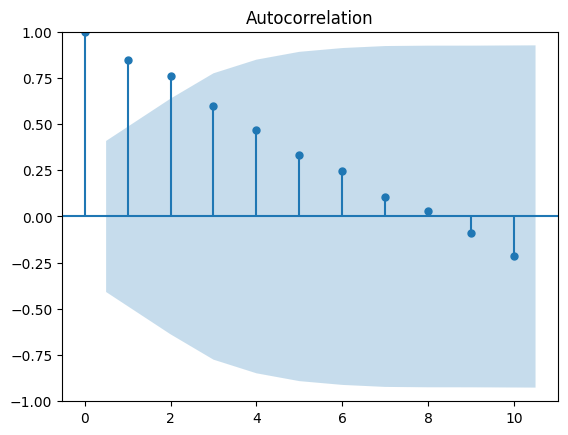

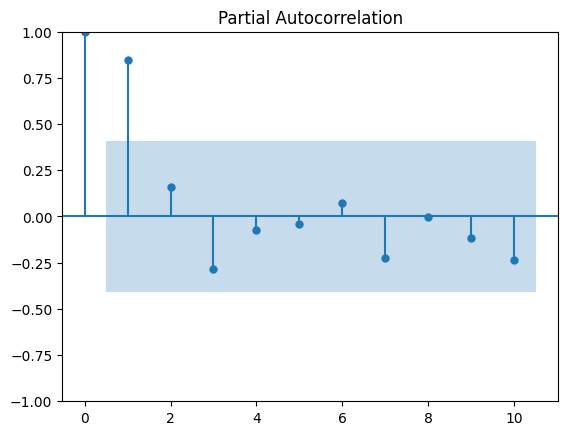

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

data = np.array(monthly_sales.drop(columns='purchase_month')['monthly_sales'])

fig_acf = plot_acf(data, lags=10)
fig_pacf = plot_pacf(data, lags=10, method='ywm')

##### Fit an ARIMA Model and Check the Residual ACF and Residual PACF
Using the residuals, we can iteratively test out different combinations of AR and Integration terms to check if we still see signs of an AR process

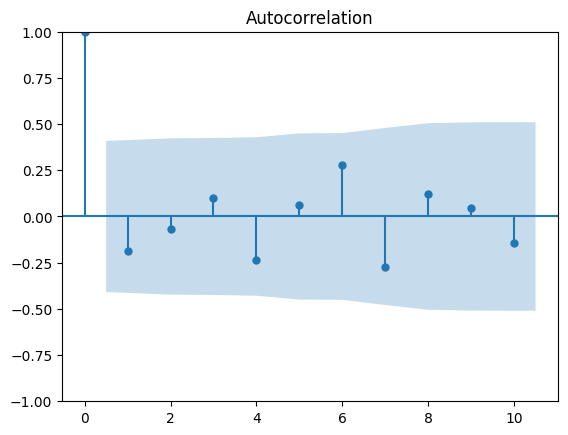

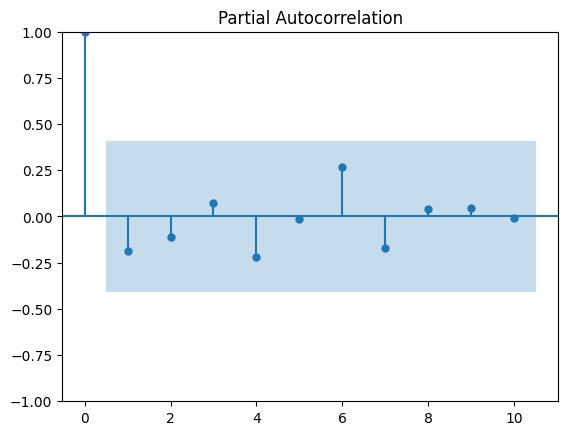

In [5]:
import statsmodels.api as sm

arima = sm.tsa.ARIMA(data, order=(2, 1, 0)).fit()

residual_acf = plot_acf(arima.resid, lags=10)
residual_pacf = plot_pacf(arima.resid, lags=10, method='ywm')

##### Make Predictions using the Fitted ARIMA Model

In [6]:
predictions = pd.DataFrame([list(data) + list(arima.forecast(3)), ['Actuals']*23 + ['Forecasted']*3]).T
predictions.columns = ['monthly_sales', 'forecast']
px.line(
    predictions, y='monthly_sales', color='forecast',
    template='simple_white', width=900, height=400,
    color_discrete_map={
        'Actuals': '#B22222',
        'Forecasted': '#8d8d8d'
    })

### **Determine the three best selling categories, and create a forecast of growth in those categories**
---

##### Determine and plot the sales of the top 3 best selling categories

In [24]:
# Combine orders, order_items, and products
order_items_products = (
    orders.select(['order_id', 'order_purchase_timestamp'])
    .join(
        order_items.select(['order_id', 'product_id', 'price']),
        on='order_id')
    .join(
        products.select(['product_id', 'product_category_name']),
        on='product_id')
)

# Get the top 3 product categories by sales volume (sum of price)
top_categories_by_sales = (
    order_items_products.select(['product_category_name', 'price'])
    .groupby('product_category_name')
    .agg(pl.col('price').sum().alias('total_sales'))
    .sort(by='total_sales', reverse=True)
    .head(3)
)

top_3_categories = list(top_categories_by_sales['product_category_name'])

# Create a dataframe with monthly sales data for each of the top categories
top_products_detail = (
    order_items_products
    .filter(pl.col('product_category_name').is_in(top_3_categories))
    .with_columns(
        (pl.col('order_purchase_timestamp').str.strptime(pl.Datetime).cast(pl.Date).dt.truncate("1mo").alias('purchase_month')))
    .drop(columns='order_purchase_timestamp')
    .groupby(['purchase_month', 'product_category_name'])
    .agg(pl.col('price').sum().alias('total_sales'))
    .sort(by=['product_category_name', 'purchase_month'])
    .to_pandas()
)

# Plot the results over each month
fig = px.line(
    top_products_detail, x='purchase_month', y='total_sales',
    color='product_category_name', markers=False, width=900, height=400,
    color_discrete_map= {
        "beleza_saude": "#010101",
        "relogios_presentes": "#8d8d8d",
        "cama_mesa_banho": '#B22222'},
    labels = {
        "purchase_month": "Purchase Month",
        "total_sales": "Total Sales",
        "product_category_name": "Product Category"},
    title='Monthly Sales of the Top 3 all-time Product Categories',
    template='simple_white')
fig.show()

##### Forecast 3 Periods into the Future for each Product Category

In [25]:
# Convert Frame back to Polars
top_products_detail = pl.DataFrame(top_products_detail)

# Create individual frames for each of the top product categories
beauty_health = list(top_products_detail.filter(pl.col('product_category_name') == 'beleza_saude').select('total_sales').to_pandas()['total_sales'])[1:]
watches_gifts = list(top_products_detail.filter(pl.col('product_category_name') == 'relogios_presentes').select('total_sales').to_pandas()['total_sales'])
bed_table_bath = list(top_products_detail.filter(pl.col('product_category_name') == 'cama_mesa_banho').select('total_sales').to_pandas()['total_sales'])

# Create and plot the forecasts for each product category
all_plots = []
for data, color in zip([beauty_health, watches_gifts, bed_table_bath], ['#010101', '#8d8d8d', '#B22222']):
    model = ExponentialSmoothing(data, trend='add', damped_trend=True).fit()
    predictions = pd.DataFrame([data + list(model.forecast(3)), ['Actuals']*len(data) + ['Forecasted']*3]).T
    predictions.columns = ['monthly_sales', 'forecast']
    fig = px.line(
        predictions, y='monthly_sales',
        template='simple_white', width=900, height=400, markers=True,
        color_discrete_map={
            'Actuals': '#B22222',
            'Forecasted': '#8d8d8d'
        })
    fig.add_vrect(
        x0=len(data),
        x1=len(data) + 2,
        fillcolor="black",
        opacity=0.1,
        line_width=0,
    )
    
    fig.update_traces(
        line_color=color,
        line_width=2
    )
    all_plots.append(fig)

fig1 = all_plots[0]
fig2 = all_plots[1]
fig3 = all_plots[2]

fig = go.Figure(data=fig1.data + fig2.data + fig3.data)

fig.update_layout(
    title="Exponential Smoothing Forecasts for Product Categories {Beauty & Health, Watches & Gifts, Bed Table & Bath}",
    template='plotly_white',
    width=1100,
    xaxis_title='Periods',
    yaxis_title='Total Sales')

fig.add_vrect(
        x0=len(data),
        x1=len(data) + 2,
        fillcolor="black",
        opacity=0.1,
        line_width=0,
    )

fig.show()

## Determine the fastest-growing category, and create a forecast for its growth

---

In [38]:
# Monthly Sales Aggregation per Product Category
monthly_sales_by_category = (
    orders.select(['order_id', 'order_purchase_timestamp'])
    .join(
        order_items.select(['order_id', 'product_id', 'price']),
        on='order_id')
    .join(
        products.select(['product_id', 'product_category_name']),
        on='product_id')
    .filter(pl.col('product_category_name').is_not_null())
    .with_columns(
        (pl.col('order_purchase_timestamp').str.strptime(pl.Datetime).cast(pl.Date).dt.truncate("1mo").alias('purchase_month')))
    .drop(columns='order_purchase_timestamp')
    .groupby(['purchase_month', 'product_category_name'])
    .agg(pl.col('price').sum().alias('total_sales'))
    .sort(by=['product_category_name', 'purchase_month'])
    .to_pandas()
)

# remove first month of sales for each category
monthly_sales_by_category['sequence'] = monthly_sales_by_category.groupby(['product_category_name']).cumcount()
monthly_sales_by_category = monthly_sales_by_category.query('sequence != 0').drop(columns='sequence')

# Calculate the growth of each categories from its base value
base_values = monthly_sales_by_category.groupby(['product_category_name'])['total_sales'].first().reset_index()
base_values.columns = ['product_category_name', 'base_sales']
monthly_sales_by_category = monthly_sales_by_category.merge(base_values, on='product_category_name')
monthly_sales_by_category['change'] = round((monthly_sales_by_category['total_sales'] / monthly_sales_by_category['base_sales']) * 100 - 100, 2)

# Get the top 25 categories with the largest median MoM growth from Base Value
top_growth_categories = (
    list(
        monthly_sales_by_category
        .groupby(['product_category_name'])['change'].median()
        .sort_values()
        .tail(25)
        .reset_index()['product_category_name'])
)

# Plot the top 25 growth categories
fig = px.line(
    monthly_sales_by_category[monthly_sales_by_category['product_category_name'].isin(top_growth_categories)],
    x='purchase_month',
    y='change',
    template='plotly_white',
    line_shape='spline',
    color='product_category_name',
    markers='dot',
    render_mode='svg',
    width=1250, height=450,
    labels={
        'purchase_month': 'Month of Purchases',
        'change': 'Sales Delta',
        'product_category_name': 'Product Category'},
    title='Change in Sales Compared to Sales in Month 1 of each Product Category')

fig.show()